In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
tf.keras.utils.set_random_seed(42)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
print("Device:", tpu.master())

     |████████████████████████████████| 133 kB 4.9 MB/s 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.75.129.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.75.129.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Device: grpc://10.75.129.98:8470


In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [4]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#getting dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [6]:
#checking train and test size
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


# EDA

In [7]:
#Look at labels for training set- they are numeric
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]



In [8]:
#plotting some of the pictures from the dataset
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [9]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [10]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

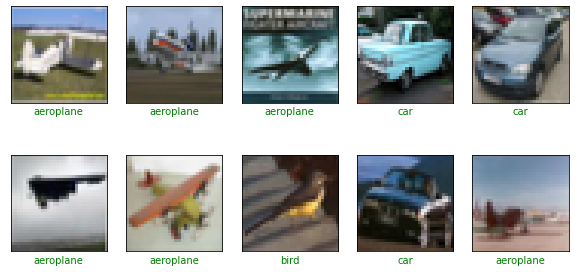

In [11]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

# Data Preprocessing

In [12]:
#use train_test_split to create validation set.
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=10
                                                                              ,shuffle=True)

In [13]:
#looking at train, validation and test set shapes
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [14]:
#scaling the train, validation and test sets by 255. Equivelant to min_max scaling

x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# Helpful Model Fitting and Results Functions

In [15]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [16]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer='adam',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=512,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=0),
     
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') 
                                                                      
  

    return history, model

In [17]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [18]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [19]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [20]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                     #index = [0,1,2,3,4,5,6,7,8,9], 
                     #columns = [0,1,2,3,4,5,6,7,8,9]
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# Experiment 5b_1 - Hyperparameter Tuning with ANN architecture

In [21]:
#Experiment 5b_1 model 
#create model for KerasTuner hyperparameter testing
def create_model_exp_5b_1(hp):
    
    model=Sequential()
    model.add(Flatten(input_shape=(32,32,3)))
    #tunning for a choice of 2 or 3 hidden layers
    for i in range(hp.Int("number_layers",2,3)):
        #within each layer testing for a min of 32 nodes, a max of 256 nodes and any in between by 
        #multiples of 32. Also testing for activation of "relu" or "tanh"
        model.add(Dense(units=hp.Int(f"nodes_{i}", min_value=32, max_value=256, step=32),
                        activation=hp.Choice("activation_{}".format(i), ["relu", "tanh"])))
        #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
        model.add(Dropout (hp.Float("dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(10, activation="softmax"))    
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

create_model_exp_5b_1(kt.HyperParameters())


In [22]:
#create tpu strategy
strategy_5b_1 = tf.distribute.TPUStrategy(tpu) 
#Bayesian Optimization Algorithm for KerasTuner
tuner_exp_5b_1 = kt.BayesianOptimization(
    hypermodel=create_model_exp_5b_1,
    objective="val_accuracy",
    max_trials=20,
    overwrite=True,
    distribution_strategy=strategy_5b_1,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_2/keras_tuner_out',
    project_name="exp_5b_1")


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [23]:
#setting epochs, patience and early stopping
epochs=100
patience=3
model_number="5b_1"
early_stopping= EarlyStopping(patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_5b_1.search(x_train_norm, y_train_split, epochs=epochs, batch_size=512, validation_data=(x_valid_norm, y_valid_split), callbacks= [early_stopping])


Trial 20 Complete [00h 01m 14s]
val_accuracy: 0.5083999633789062

Best val_accuracy So Far: 0.5231999754905701
Total elapsed time: 00h 37m 15s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [24]:
#getting best hyperparameters
best_hyper_parameters_exp_5b_1=tuner_exp_5b_1.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many hidden layers there are
def best_model_hyperparameters_exp_5b_1(bhp):
    num_layers=bhp.get('number_layers')
    print("Number of layers: {}".format(num_layers))
    print("\n")
    for i in range(0,num_layers):
        print("Number of nodes in layer_{}:".format(i), bhp.get("nodes_{}".format(i)))
        print("Activation function for layer_{}:".format(i), bhp.get("activation_{}".format(i)))
        print("Dropout in layer_{}:".format(i), bhp.get("dropout_{}".format(i)))
        print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_exp_5b_1(best_hyper_parameters_exp_5b_1)                                                              


Number of layers: 2


Number of nodes in layer_0: 256
Activation function for layer_0: relu
Dropout in layer_0: 0.1


Number of nodes in layer_1: 96
Activation function for layer_1: tanh
Dropout in layer_1: 0.1


Optimizer Used: adam


In [25]:
#creating tpu strategy for best 5b_1 model
strategy_5b_1_best  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [26]:
#getting paremeters of best model
model_exp_5b_1_best_params = tuner_exp_5b_1.get_best_hyperparameters(2)
# Building model exp_5b_1 with best hyper parameters
with strategy_5b_1_best.scope():
    model_exp_5b_1_best = create_model_exp_5b_1(model_exp_5b_1_best_params[0])

In [27]:
model_exp_5b_1_best.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               786688    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 96)                24672     
                                                                 
 dropout_3 (Dropout)         (None, 96)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                970       
                                                                 
Total params: 812,330
Trainable params: 812,330
Non-tr

In [28]:
# Running best model 5b_1 to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=100
patience=3
model_number="5b_1"
history_exp_5b_1_best, model_exp_5b_1_best = compile_train_model(model_exp_5b_1_best,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 4/88 [>.............................] - ETA: 1s - loss: 3.0087 - accuracy: 0.1128  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.2012s). Check your callbacks.


88/88 [==============================] - 9s 63ms/step - loss: 2.2678 - accuracy: 0.1717 - val_loss: 1.9447 - val_accuracy: 0.3092
Epoch 2/100
88/88 [==============================] - 2s 25ms/step - loss: 1.9173 - accuracy: 0.3065 - val_loss: 1.7659 - val_accuracy: 0.3750
Epoch 3/100
88/88 [==============================] - 2s 26ms/step - loss: 1.7757 - accuracy: 0.3626 - val_loss: 1.7077 - val_accuracy: 0.3918
Epoch 4/100
88/88 [==============================] - 2s 25ms/step - loss: 1.7165 - accuracy: 0.3830 - val_loss: 1.6439 - val_accuracy: 0.4082
Epoch 5/100
88/88 [==============================] - 2s 26ms/step - loss: 1.6687 - accuracy: 0.4024 - val_loss: 1.6152 - val_accuracy: 0.4202
Epoch 6/100
88/88 [==============================] - 2s 25ms/step - loss: 1.6469 - accuracy: 0.4135 - val_loss: 1.5982 - val_accuracy: 0.4230
Epoch 7/100
88/88 [==============================] - 2s 25ms/step - loss: 1.6192 - accuracy: 0.4212 - val_loss: 1.5773 - val_accuracy: 0.4342
Epoch 8/100
88/88 

In [29]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_5b_1_best, model_number, epochs, patience=patience)

Model Experiment 5b_1  Training Loss:  1.3718
Model Experiment 5b_1  Training Accuracy:  0.5057
Model Experiment 5b_1  Validation Loss:  1.3918
Model Experiment 5b_1  Validation Accuracy: 0.5058


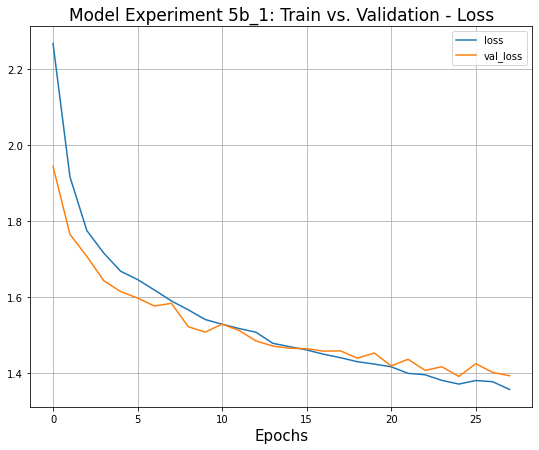

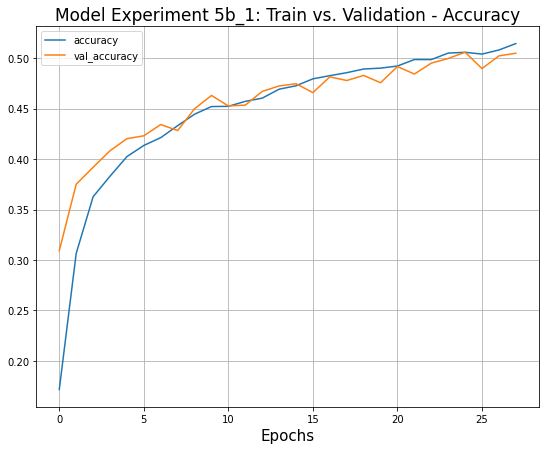

In [30]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_5b_1_best, model_number)

In [31]:
#creating  classification report

#getting predictions

model_exp_5b_1_best_predictions=model_exp_5b_1_best.predict(x_test_norm).argmax(axis=1)
print_validation_report(test_labels, model_exp_5b_1_best_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.52      0.59      0.56      1000
           1       0.61      0.62      0.62      1000
           2       0.38      0.39      0.38      1000
           3       0.36      0.29      0.32      1000
           4       0.47      0.40      0.43      1000
           5       0.42      0.38      0.40      1000
           6       0.49      0.66      0.56      1000
           7       0.57      0.56      0.57      1000
           8       0.62      0.62      0.62      1000
           9       0.57      0.53      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000

Accuracy Score: 0.5054
Root Mean Square Error: 3.082385439882559


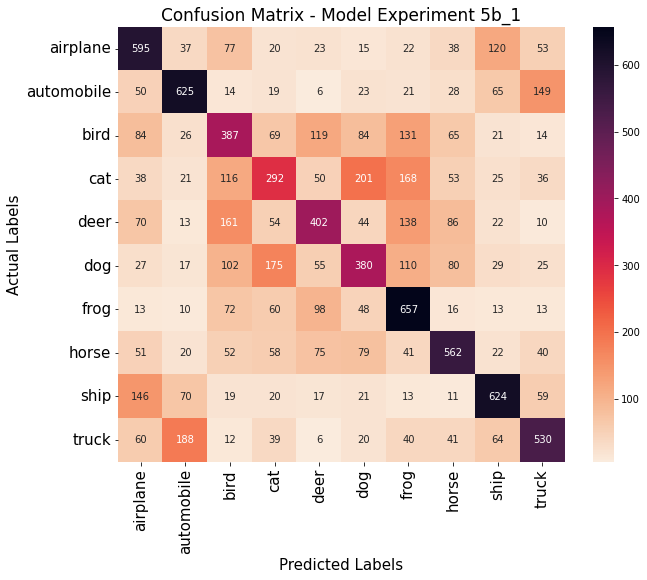

In [32]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_5b_1_best, x_test_norm, y_test, model_number)

# Experiment 5b_2 - Hyperparameter Tuning with CNN architecture

In [33]:
#Experiment 5b_2 model
def create_model_exp_5b_2(hp):
    
    model=Sequential()
    model.add(Input(shape=(32,32,3)))
    #tunning for a choice of 2 or 3 Convolutional layers
    for i in range(hp.Int("Number_Conv_layers",2,3)):
        #within each layer testing for a min of 128 filters, a max of 512 filters and any in between by 
        #multiples of 128. Also testing kernel sized 3, 4, 5. 
        model.add(Conv2D(filters=hp.Int("Conv_Filters_{}".format(i), min_value=128, max_value=512, step=128),
                        kernel_size=hp.Int('Conv_kernel_size_{}'.format(i), 3, 5),
                        padding='same',
                        activation='relu'))
        #testing strides of 1 or 2 for max pooling
        model.add(MaxPool2D(pool_size=(2,2), 
                  strides=hp.Int("Max_Pool_strides_{}".format(i), 1,2     )))
        #testing for dropout of values 0.1 to 0.40  by increments of 0.1 after every MaxPool layer
        model.add(Dropout (hp.Float("Conv_Dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Flatten())
    #testing for number of nodes from 128 to 512 by multiples of 128 for the dense layer
    model.add(Dense(units=hp.Int("Dense_nodes", min_value=128, max_value=512, step=128), activation="relu"))
    model.add(BatchNormalization())
    #testing for dropout of values 0.1 to 0.4 by increments of 0.1
    model.add(Dropout (hp.Float("Dropout_Dense_{}", min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(10, activation = "softmax"))
    
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

create_model_exp_5b_2(kt.HyperParameters())

In [36]:
#setting up TPU strategy 
strategy_5b_2 = tf.distribute.TPUStrategy(tpu) 

#creating Bayesian Optimization for KerasTuner
tuner_exp_5b_2 = kt.BayesianOptimization(
    hypermodel=create_model_exp_5b_2,
    objective="val_accuracy",
    max_trials=20,
    overwrite=True,
    distribution_strategy=strategy_5b_2,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_2/keras_tuner_out',
    project_name="exp_5b_2")

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [37]:
#setting epochs, patience and early stopping
epochs=100
patience=3
model_number="5b_2"
early_stopping= EarlyStopping(patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_5b_2.search(x_train_norm, y_train_split, epochs=epochs, batch_size=512, validation_data=(x_valid_norm, y_valid_split), callbacks= [early_stopping])


Trial 20 Complete [00h 01m 15s]
val_accuracy: 0.6233999729156494

Best val_accuracy So Far: 0.7823999524116516
Total elapsed time: 00h 38m 57s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [38]:
#getting best hyperparameters for model 
best_hyper_parameters_exp_5b_2=tuner_exp_5b_2.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many Conv layers there are
def best_model_hyperparameters_Conv(bhp):
    num_conv_layers=bhp.get('Number_Conv_layers')
    print("Number of layers: {}".format(num_conv_layers))
    print("\n")
    for i in range(0,num_conv_layers):
        print("Number of filters in Conv_Layer_{}:".format(i), bhp.get("Conv_Filters_{}".format(i)))
        print("Kernel size for Conv Layer_{}:".format(i), bhp.get("Conv_kernel_size_{}".format(i)))
        print("Strides for Max Pooling Layer_{}:".format(i), bhp.get("Max_Pool_strides_{}".format(i)))
        print("Dropout in Conv layer_{}:".format(i), bhp.get("Conv_Dropout_{}".format(i)))
        print("\n")
    print('Number of nodes in Dense Layer:', bhp.get('Dense_nodes'))
    print('Dropout in Dense Layer:', bhp.get('Dropout_Dense_{}'))
    print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_Conv(best_hyper_parameters_exp_5b_2)  

Number of layers: 3


Number of filters in Conv_Layer_0: 128
Kernel size for Conv Layer_0: 3
Strides for Max Pooling Layer_0: 2
Dropout in Conv layer_0: 0.2


Number of filters in Conv_Layer_1: 384
Kernel size for Conv Layer_1: 4
Strides for Max Pooling Layer_1: 2
Dropout in Conv layer_1: 0.1


Number of filters in Conv_Layer_2: 128
Kernel size for Conv Layer_2: 3
Strides for Max Pooling Layer_2: 1
Dropout in Conv layer_2: 0.1


Number of nodes in Dense Layer: 256
Dropout in Dense Layer: 0.1


Optimizer Used: adam


In [39]:
#setting up TPU strategy to run best 5b_2 model
strategy_5b_2_best = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [40]:
#getting paremeters of best model
model_exp_5b_2_best_params = tuner_exp_5b_2.get_best_hyperparameters(2)
# Building model exp_5b_2 with best hyper parameters
with strategy_5b_2_best.scope():
    model_exp_5b_2_best = create_model_exp_5b_2(model_exp_5b_2_best_params[0])





In [41]:
model_exp_5b_2_best.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 384)       786816    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 384)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 384)        

In [42]:
# Running best model 5b_2 to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=100
patience=3
model_number="5b_2"
history_exp_5b_2_best, model_exp_5b_2_best = compile_train_model(model_exp_5b_2_best,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
 5/88 [>.............................] - ETA: 2s - loss: 2.3619 - accuracy: 0.1793WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_train_batch_end` time: 0.7458s). Check your callbacks.


88/88 [==============================] - 19s 133ms/step - loss: 1.5739 - accuracy: 0.4351 - val_loss: 1.6892 - val_accuracy: 0.4658
Epoch 2/100
88/88 [==============================] - 3s 34ms/step - loss: 1.0784 - accuracy: 0.6190 - val_loss: 1.4757 - val_accuracy: 0.5730
Epoch 3/100
88/88 [==============================] - 3s 34ms/step - loss: 0.8747 - accuracy: 0.6947 - val_loss: 1.1005 - val_accuracy: 0.6366
Epoch 4/100
88/88 [==============================] - 3s 33ms/step - loss: 0.7535 - accuracy: 0.7373 - val_loss: 0.9290 - val_accuracy: 0.7014
Epoch 5/100
88/88 [==============================] - 3s 33ms/step - loss: 0.6671 - accuracy: 0.7675 - val_loss: 0.8573 - val_accuracy: 0.7002
Epoch 6/100
88/88 [==============================] - 3s 33ms/step - loss: 0.5981 - accuracy: 0.7905 - val_loss: 0.9086 - val_accuracy: 0.6886
Epoch 7/100
88/88 [==============================] - 3s 33ms/step - loss: 0.5305 - accuracy: 0.8138 - val_loss: 0.7031 - val_accuracy: 0.7586
Epoch 8/100
88/8

In [43]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_5b_2_best, model_number, epochs, patience=patience)

Model Experiment 5b_2  Training Loss:  0.1894
Model Experiment 5b_2  Training Accuracy:  0.9346
Model Experiment 5b_2  Validation Loss:  0.8088
Model Experiment 5b_2  Validation Accuracy: 0.787


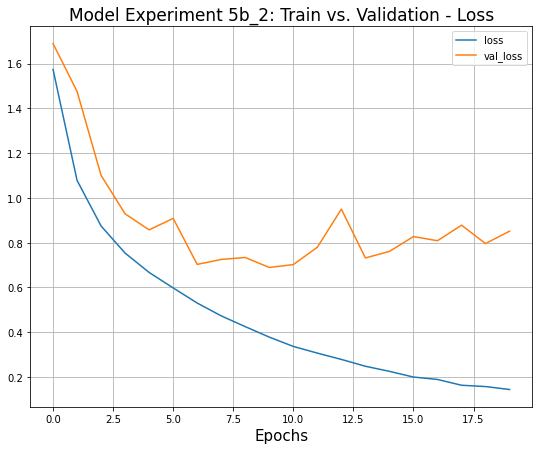

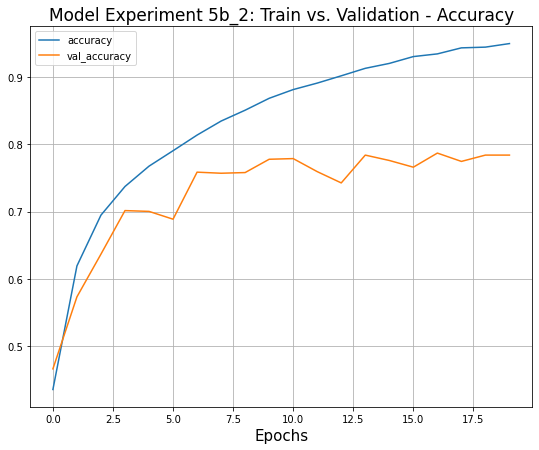

In [44]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_5b_2_best, model_number)

In [45]:
#creating  classification report

#getting predictions

model_exp_5b_2_best_predictions=model_exp_5b_2_best.predict(x_test_norm).argmax(axis=1)
print_validation_report(test_labels, model_exp_5b_2_best_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1000
           1       0.89      0.90      0.89      1000
           2       0.72      0.69      0.70      1000
           3       0.62      0.60      0.61      1000
           4       0.78      0.72      0.75      1000
           5       0.61      0.80      0.69      1000
           6       0.90      0.77      0.83      1000
           7       0.74      0.89      0.81      1000
           8       0.89      0.87      0.88      1000
           9       0.89      0.83      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

Accuracy Score: 0.7833
Root Mean Square Error: 1.8229920460605418


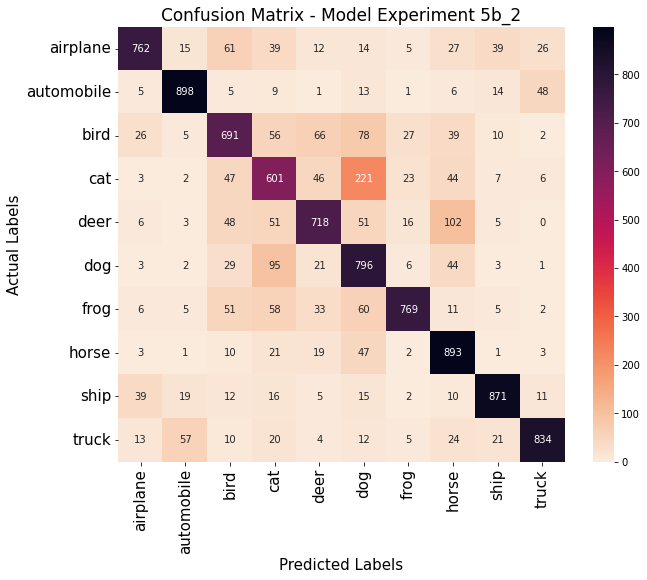

In [46]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_5b_2_best, x_test_norm, y_test, model_number)